# `EmissionAbsorptionFFModel` Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate the basic features of the `EmissionAbsorptionFFModel` model. `EmissionAbsorptionFFModel` models both 21cm emission and absorption observations allowing for a "filling factor" term to account for beam dilution effects in the emission spectra.

In [1]:
# General imports
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

print("pymc version:", pm.__version__)

import bayes_spec

print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi

print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b0+0.g8f8b122.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionAbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observations to be named `"emission"` and `"absorption"`.

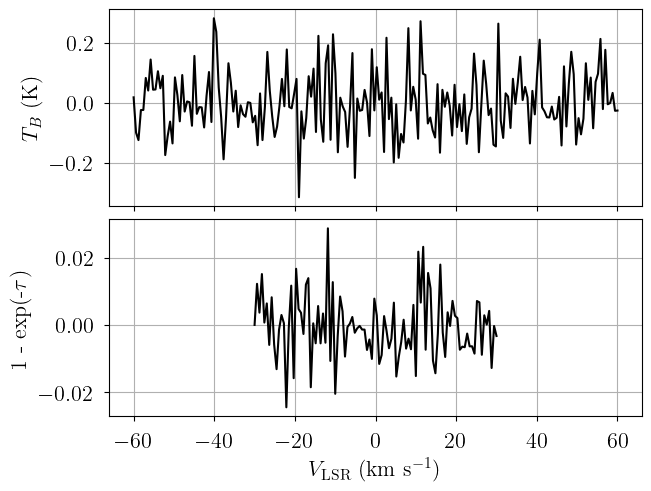

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1  # K
rms_absorption = 0.01  # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
axes[1].plot(
    dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-"
)
axes[1].set_xlabel(dummy_data["emission"].xlabel)
axes[0].set_ylabel(dummy_data["emission"].ylabel)
_ = axes[1].set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood.

In [3]:
from caribou_hi import EmissionAbsorptionFFModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionFFModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

In [4]:
# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 20.5]),
    "log10_depth": np.array([1.5, 0.5, 2.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.0]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

sim_params_emission = sim_params.copy()
sim_params_emission["filling_factor"] = np.array([0.2, 0.5, 1.0])
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)",
    ),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)",
    ),
}

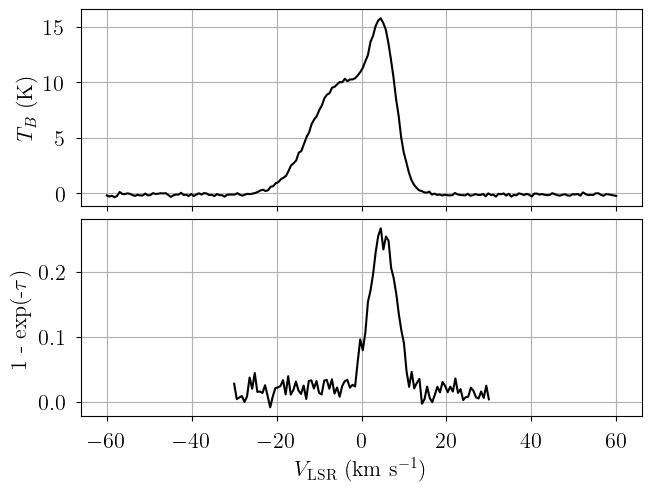

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `TauModel`. Here we create a new model with the simulated data.

In [6]:
# Initialize and define the model
model = EmissionAbsorptionFFModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp=3.77,  # assumed background temperature (K)
    seed=1234,
    verbose=True,
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.01,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

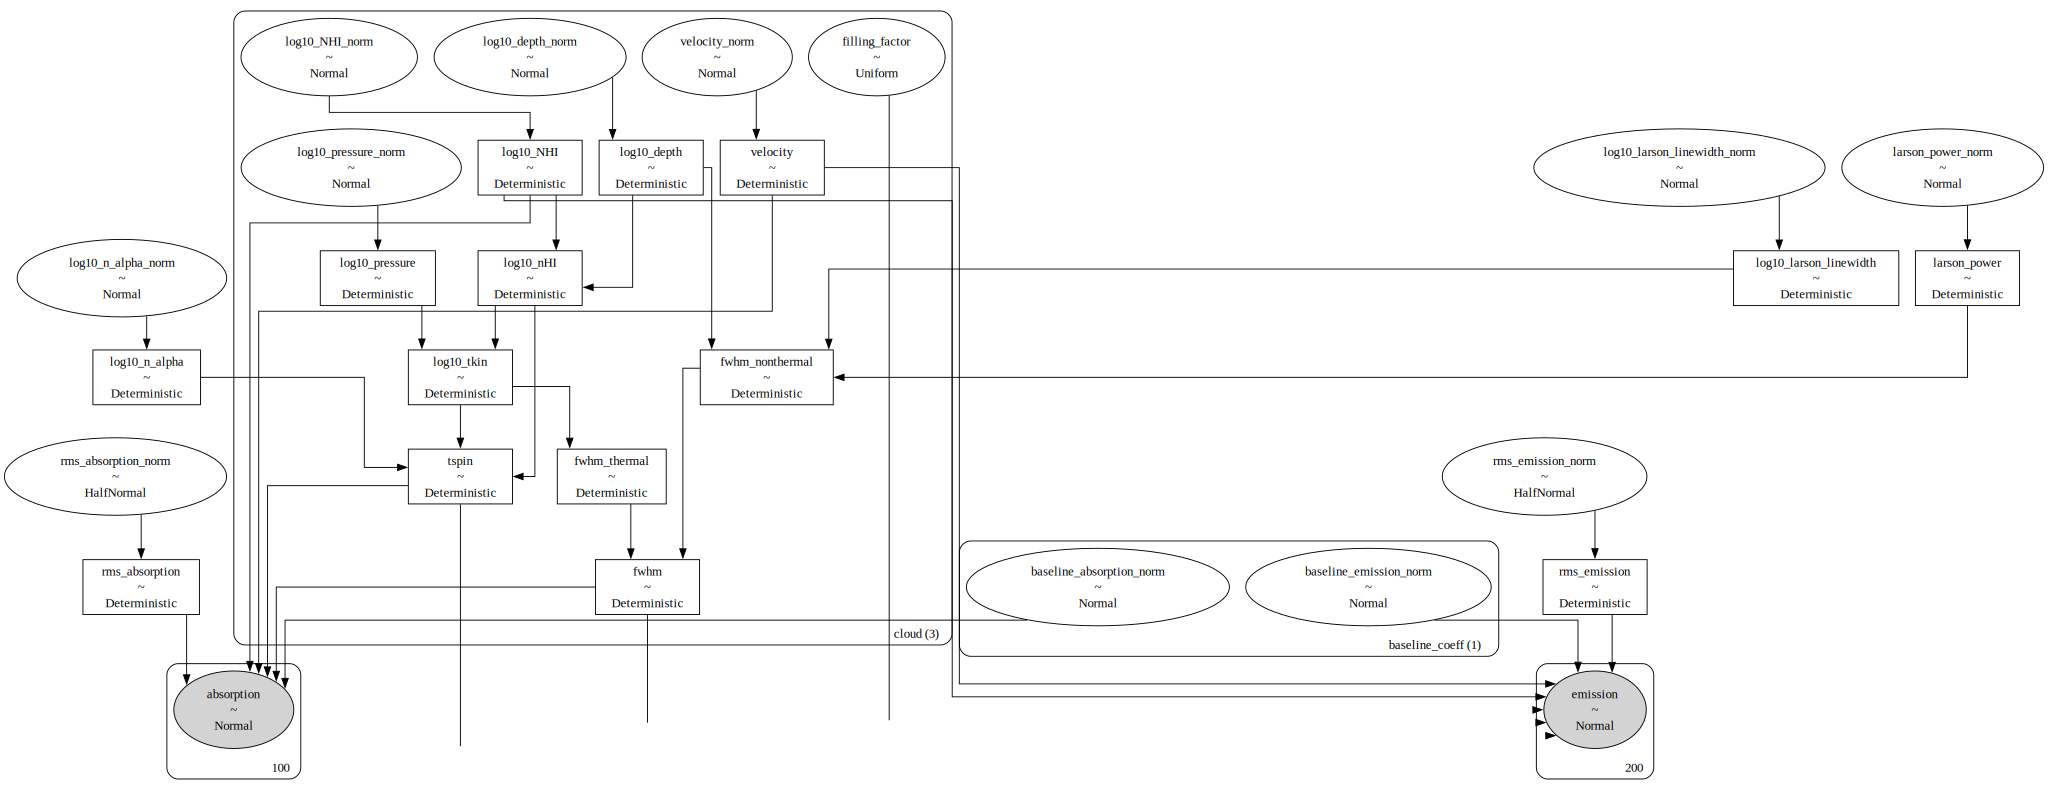

In [7]:
# Plot model graph
model.graph().render("emission_absorption_ff_model", format="png")
model.graph()

In [8]:
# model string representation
print(model.model.str_repr())

     baseline_emission_norm ~ Normal(0, 1)
   baseline_absorption_norm ~ Normal(0, 1)
             log10_NHI_norm ~ Normal(0, 1)
           log10_depth_norm ~ Normal(0, 1)
        log10_pressure_norm ~ Normal(0, 1)
              velocity_norm ~ Normal(0, 1)
         log10_n_alpha_norm ~ Normal(0, 1)
log10_larson_linewidth_norm ~ Normal(0, 1)
          larson_power_norm ~ Normal(0, 1)
             filling_factor ~ Uniform(0, 1)
          rms_emission_norm ~ HalfNormal(0, 1)
        rms_absorption_norm ~ HalfNormal(0, 1)
                  log10_NHI ~ Deterministic(f(log10_NHI_norm))
                log10_depth ~ Deterministic(f(log10_depth_norm))
             log10_pressure ~ Deterministic(f(log10_pressure_norm))
                   velocity ~ Deterministic(f(velocity_norm))
              log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_larson_linewidth ~ Deterministic(f(log10_larson_linewidth_norm))
               larson_power ~ Deterministic(f(larson_power_norm))
        

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, baseline_emission_norm, emission, filling_factor, larson_power_norm, log10_NHI_norm, log10_depth_norm, log10_larson_linewidth_norm, log10_n_alpha_norm, log10_pressure_norm, rms_absorption_norm, rms_emission_norm, velocity_norm]


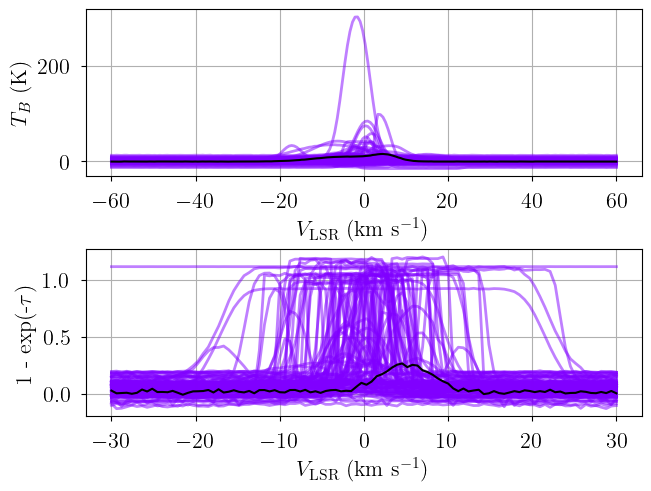

In [9]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

Or we can inspect the prior distributions of the derived quantities to check that they are physically reasonable.

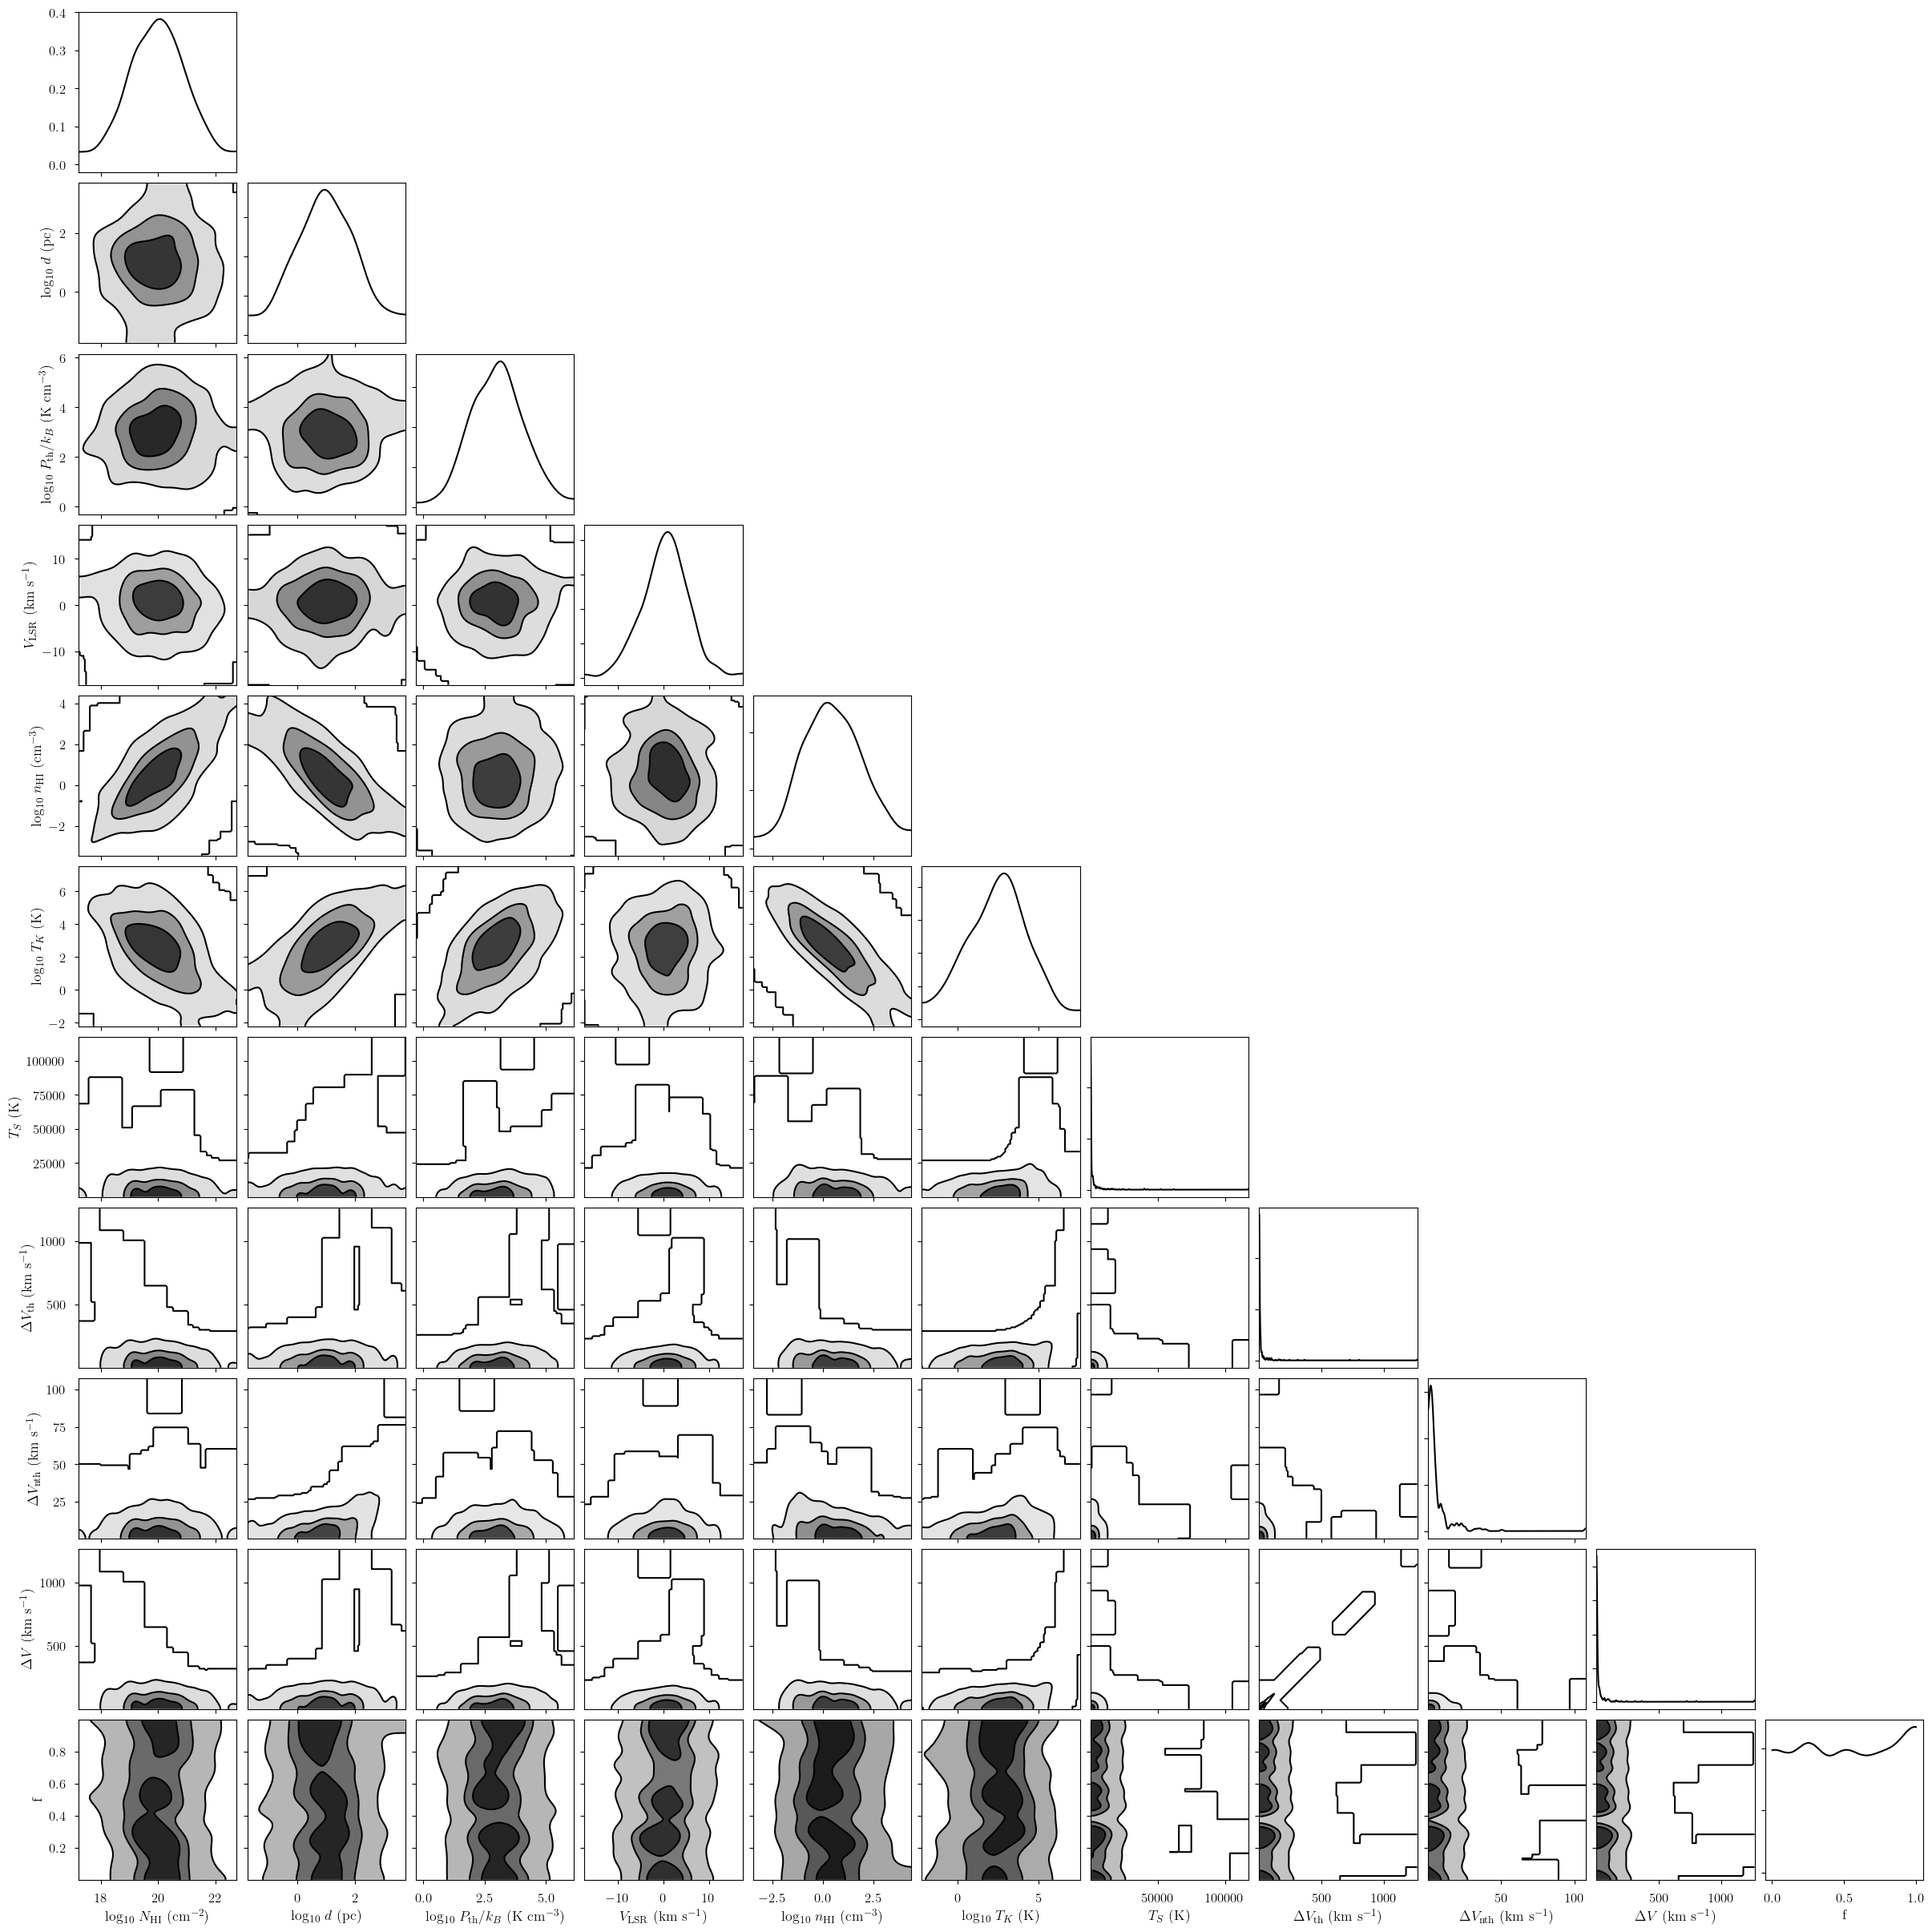

In [10]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior,  # samples
    model.cloud_deterministics + ["filling_factor"],  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [11]:
start = time.time()
model.fit(
    n=100_000,  # maximum number of VI iterations
    draws=1_000,  # number of posterior samples
    rel_tolerance=0.01,  # VI relative convergence threshold
    abs_tolerance=0.05,  # VI absolute convergence threshold
    learning_rate=1e-2,  # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 7700
Interrupted at 7,699 [7%]: Average Loss = 12,201


Output()

Runtime: 1.81 minutes


In [12]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd    hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.506   0.020    -0.541    -0.469      0.001   
baseline_emission_norm[0]      -0.523   0.002    -0.526    -0.519      0.000   
filling_factor[0]               0.680   0.008     0.664     0.695      0.000   
filling_factor[1]               0.805   0.003     0.800     0.810      0.000   
filling_factor[2]               0.837   0.003     0.832     0.841      0.000   
fwhm[0]                        11.582   0.269    11.068    12.060      0.008   
fwhm[1]                        16.024   0.113    15.835    16.242      0.004   
fwhm[2]                         6.572   0.041     6.501     6.650      0.001   
fwhm_nonthermal[0]             10.464   0.181    10.157    10.825      0.006   
fwhm_nonthermal[1]             14.213   0.100    14.039    14.405      0.003   
fwhm_nonthermal[2]              6.359   0.041     6.289     6.436      0.001   
fwhm_thermal[0]                 4.951   0.427     4.103     5.751      0.013   
fwhm_thermal[1]                 7.399   0.141     7.166     7.679      0.005   
fwhm_thermal[2]                 1.659   0.016     1.631     1.688      0.001   
larson_power                    0.463   0.001     0.461     0.465      0.000   
larson_power_norm               0.632   0.011     0.611     0.652      0.000   
log10_NHI[0]                   19.952   0.005    19.943    19.962      0.000   
log10_NHI[1]                   20.538   0.001    20.536    20.541      0.000   
log10_NHI[2]                   20.329   0.002    20.325    20.333      0.000   
log10_NHI_norm[0]              -0.048   0.005    -0.057    -0.038      0.000   
log10_NHI_norm[1]               0.538   0.001     0.536     0.541      0.000   
log10_NHI_norm[2]               0.329   0.002     0.325     0.333      0.000   
log10_depth[0]                  1.571   0.015     1.542     1.599      0.000   
log10_depth[1]                  1.858   0.003     1.852     1.865      0.000   
log10_depth[2]                  1.104   0.004     1.096     1.112      0.000   
log10_depth_norm[0]             0.571   0.015     0.542     0.599      0.000   
log10_depth_norm[1]             0.858   0.003     0.852     0.865      0.000   
log10_depth_norm[2]             0.104   0.004     0.096     0.112      0.000   
log10_larson_linewidth          0.292   0.002     0.289     0.295      0.000   
log10_larson_linewidth_norm     0.920   0.016     0.891     0.952      0.001   
log10_nHI[0]                   -0.108   0.016    -0.138    -0.078      0.001   
log10_nHI[1]                    0.191   0.004     0.184     0.198      0.000   
log10_nHI[2]                    0.735   0.005     0.727     0.744      0.000   
log10_n_alpha                  -5.802   0.958    -7.496    -4.079      0.035   
log10_n_alpha_norm              0.198   0.958    -1.496     1.921      0.035   
log10_pressure[0]               2.659   0.073     2.533     2.811      0.002   
log10_pressure[1]               3.310   0.016     3.281     3.342      0.001   
log10_pressure[2]               2.556   0.007     2.545     2.571      0.000   
log10_pressure_norm[0]         -0.341   0.073    -0.467    -0.189      0.002   
log10_pressure_norm[1]          0.310   0.016     0.281     0.342      0.001   
log10_pressure_norm[2]         -0.444   0.007    -0.455    -0.429      0.000   
log10_tkin[0]                   2.726   0.074     2.586     2.877      0.002   
log10_tkin[1]                   3.078   0.017     3.050     3.110      0.001   
log10_tkin[2]                   1.779   0.008     1.764     1.794      0.000   
rms_absorption                  0.012   0.001     0.010     0.014      0.000   
rms_absorption_norm             1.171   0.099     0.991     1.361      0.003   
rms_emission                    0.104   0.005     0.094     0.114      0.000   
rms_emission_norm               1.041   0.055     0.942     1.139      0.002   
tspin[0]                      526.635  90.585   355.251   693.972      2.799   
tspin[1]                     1154

Sampling: [absorption, emission]


Output()

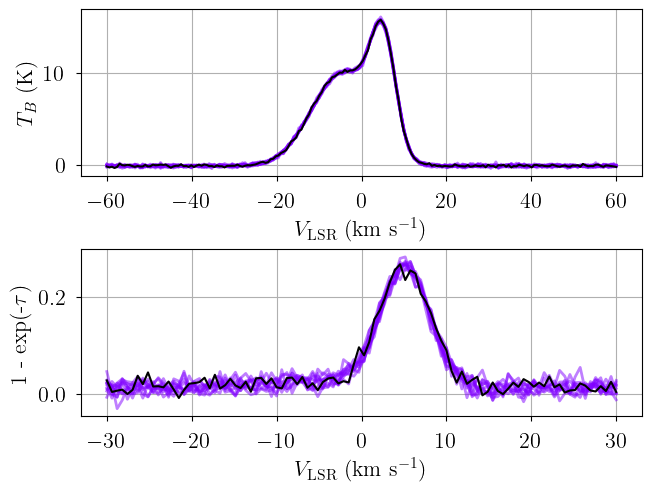

In [13]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

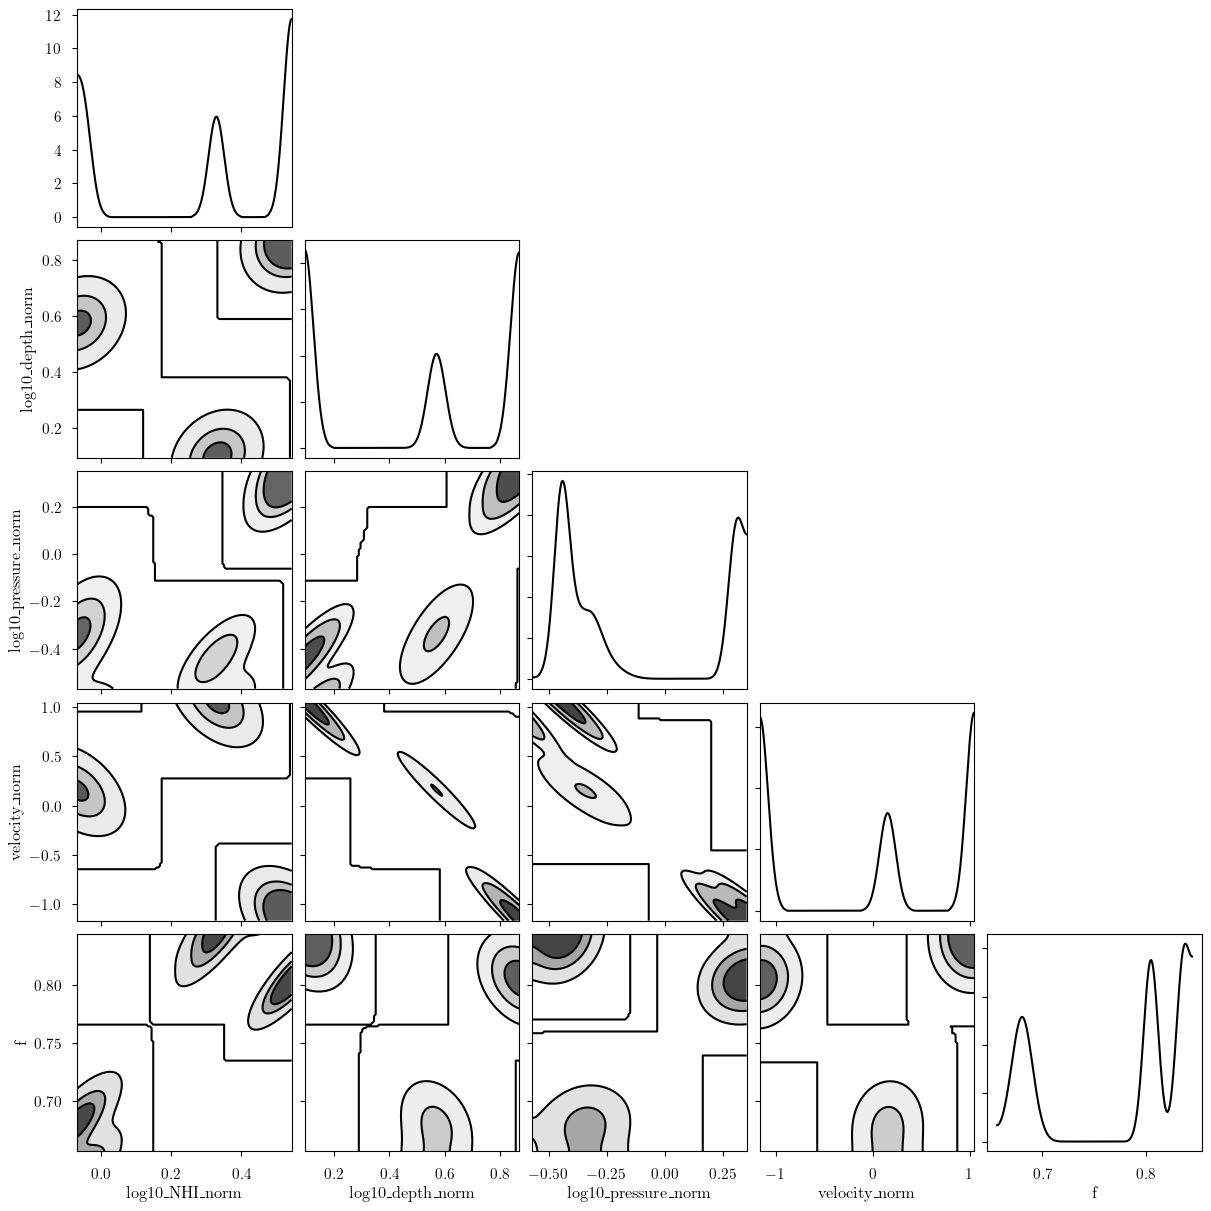

In [14]:
_ = plot_pair(
    model.trace.posterior,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [15]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=4,  # number of independent chains
    cores=4,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.05,
        "learning_rate": 1e-2,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7700
Interrupted at 7,699 [7%]: Average Loss = 12,201
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, filling_factor, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1676 seconds.


Adding log-likelihood to trace


Output()

There were 40 divergences in converged chains.
Runtime: 29.03 minutes


In [16]:
model.solve()

GMM converged to unique solution
3 of 4 chains appear converged.


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [17]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd    hdi_3%   hdi_97%  \
baseline_absorption_norm[0]    -0.472     0.022    -0.511    -0.428   
baseline_emission_norm[0]      -0.522     0.002    -0.525    -0.518   
filling_factor[0]               0.549     0.238     0.183     0.973   
filling_factor[1]               0.665     0.209     0.314     1.000   
filling_factor[2]               0.519     0.262     0.133     0.999   
fwhm[0]                         5.801     1.052     3.996     7.891   
fwhm[1]                        16.472     0.166    16.161    16.787   
fwhm[2]                         6.535     0.097     6.342     6.698   
fwhm_nonthermal[0]              3.333     1.584     0.510     6.135   
fwhm_nonthermal[1]              9.739     3.455     3.731    15.140   
fwhm_nonthermal[2]              5.957     0.573     4.930     6.511   
fwhm_thermal[0]                 4.474     1.062     2.392     6.352   
fwhm_thermal[1]                12.553     2.647     7.872    16.440   
fwhm_thermal[2]                 2.466     0.902     1.488     4.244   
larson_power                    0.391     0.082     0.239     0.543   
larson_power_norm              -0.086     0.822    -1.607     1.433   
log10_NHI[0]                   19.399     0.331    18.848    20.011   
log10_NHI[1]                   20.706     0.160    20.492    21.007   
log10_NHI[2]                   20.624     0.277    20.257    21.184   
log10_NHI_norm[0]              -0.601     0.331    -1.152     0.011   
log10_NHI_norm[1]               0.706     0.160     0.492     1.007   
log10_NHI_norm[2]               0.624     0.277     0.257     1.184   
log10_depth[0]                  0.657     0.578    -0.552     1.647   
log10_depth[1]                  1.914     0.523     0.887     2.873   
log10_depth[2]                  1.461     0.347     0.837     2.109   
log10_depth_norm[0]            -0.343     0.578    -1.552     0.647   
log10_depth_norm[1]             0.914     0.523    -0.113     1.873   
log10_depth_norm[2]             0.461     0.347    -0.163     1.109   
log10_larson_linewidth          0.219     0.097     0.035     0.398   
log10_larson_linewidth_norm     0.188     0.966    -1.654     1.983   
log10_nHI[0]                    0.253     0.550    -0.737     1.295   
log10_nHI[1]                    0.303     0.562    -0.666     1.446   
log10_nHI[2]                    0.674     0.449    -0.179     1.518   
log10_n_alpha                  -6.009     0.989    -7.947    -4.175   
log10_n_alpha_norm             -0.009     0.989    -1.947     1.825   
log10_pressure[0]               2.909     0.686     1.633     4.153   
log10_pressure[1]               3.859     0.691     2.637     5.187   
log10_pressure[2]               2.792     0.660     1.677     4.095   
log10_pressure_norm[0]         -0.091     0.686    -1.367     1.153   
log10_pressure_norm[1]          0.859     0.691    -0.363     2.187   
log10_pressure_norm[2]         -0.208     0.660    -1.323     1.095   
log10_tkin[0]                   2.615     0.216     2.188     3.001   
log10_tkin[1]                   3.515     0.200     3.141     3.778   
log10_tkin[2]                   2.076     0.276     1.707     2.609   
rms_absorption                  0.012     0.001     0.010     0.013   
rms_absorption_norm             1.155     0.083     1.006     1.318   
rms_emission                    0.094     0.005     0.085     0.103   
rms_emission_norm               0.939     0.048     0.855     1.034   
tspin[0]                      454.565   213.268    89.581   810.845   
tspin[1]                     3257.942  1353.851  1153.299  5618.500   
tspin[2]                      150.238   126.870    47.503   390.382   
velocity[0]                    -0.428     0.813    -1.575     1.029   
velocity[1]                    -4.920     0.140    -5.184    -4.667   
velocity[2]                     5.106     0.068     5.011     5.235   
velocity_norm[0]               -0.086     0.163    -0.315     0.206   
velocity_norm[1]               -0.984     0.028    -1.037

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption, emission]


Output()

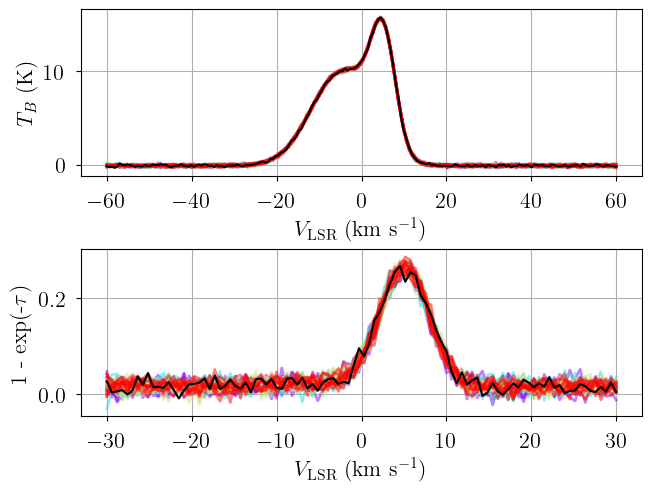

In [18]:
posterior = model.sample_posterior_predictive(
    thin=100,  # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

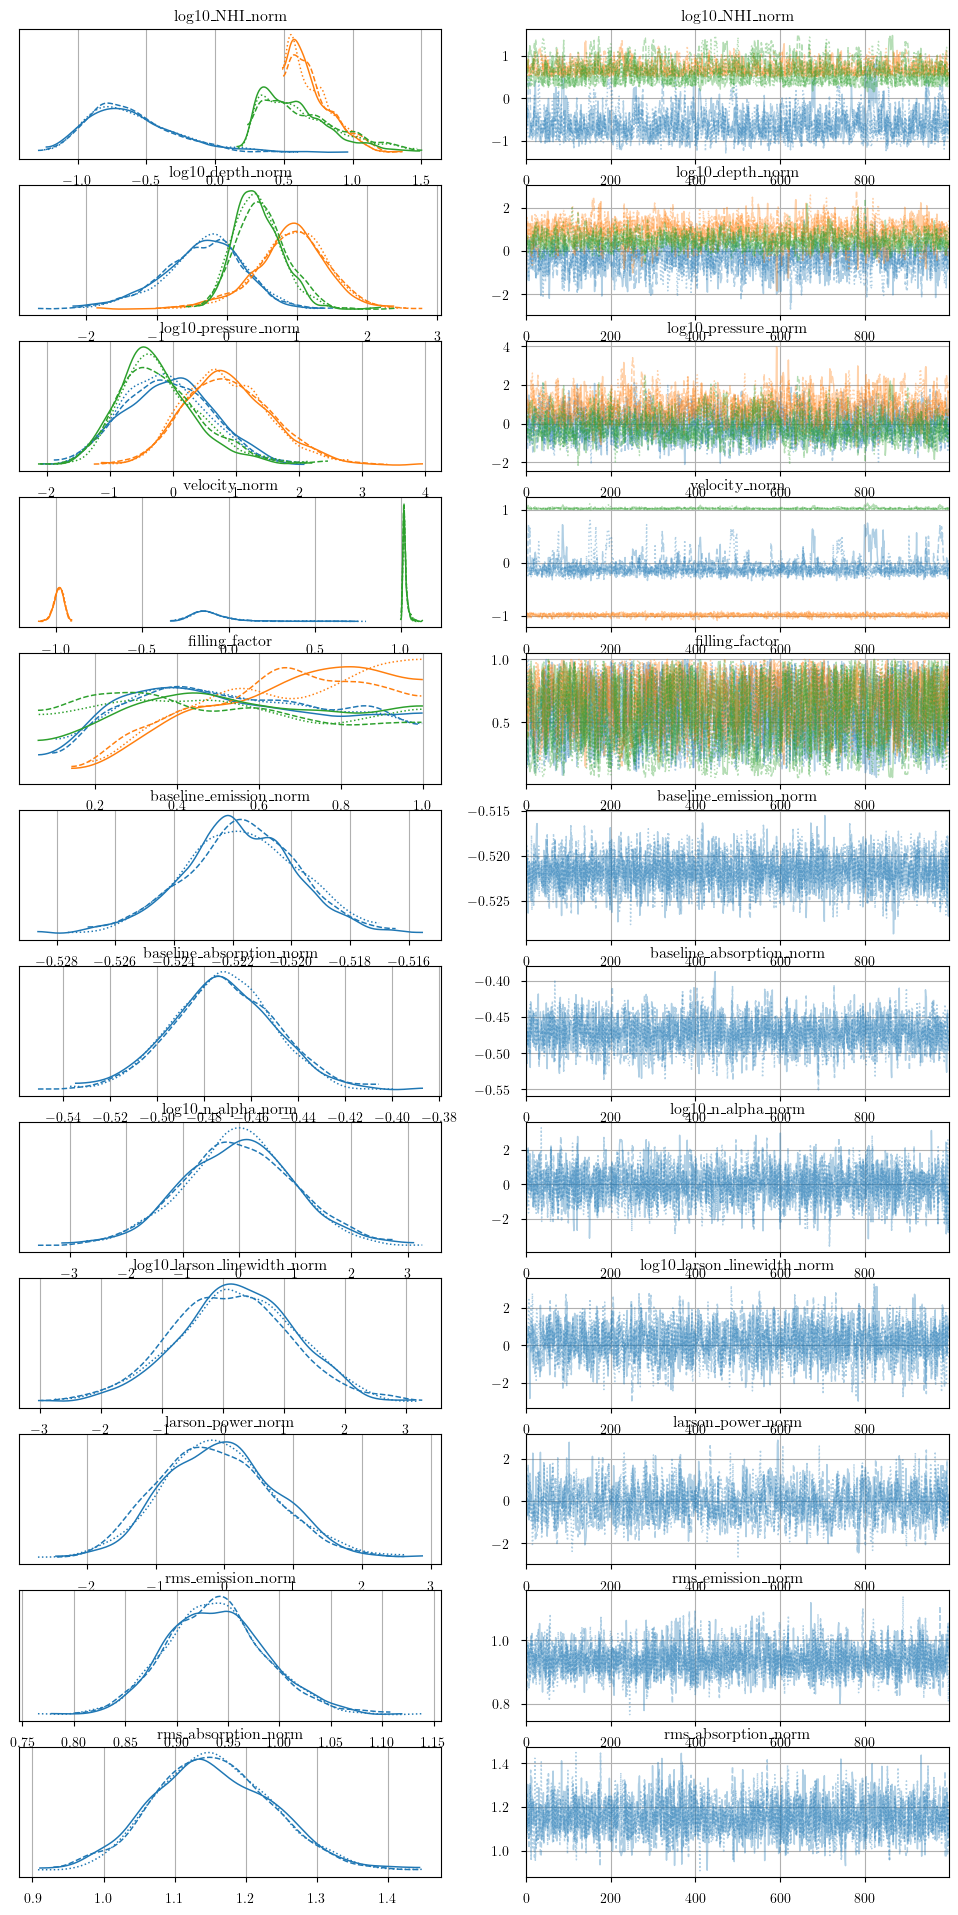

In [19]:
from bayes_spec.plots import plot_traces

_ = plot_traces(
    model.trace.solution_0,
    model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs,
)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

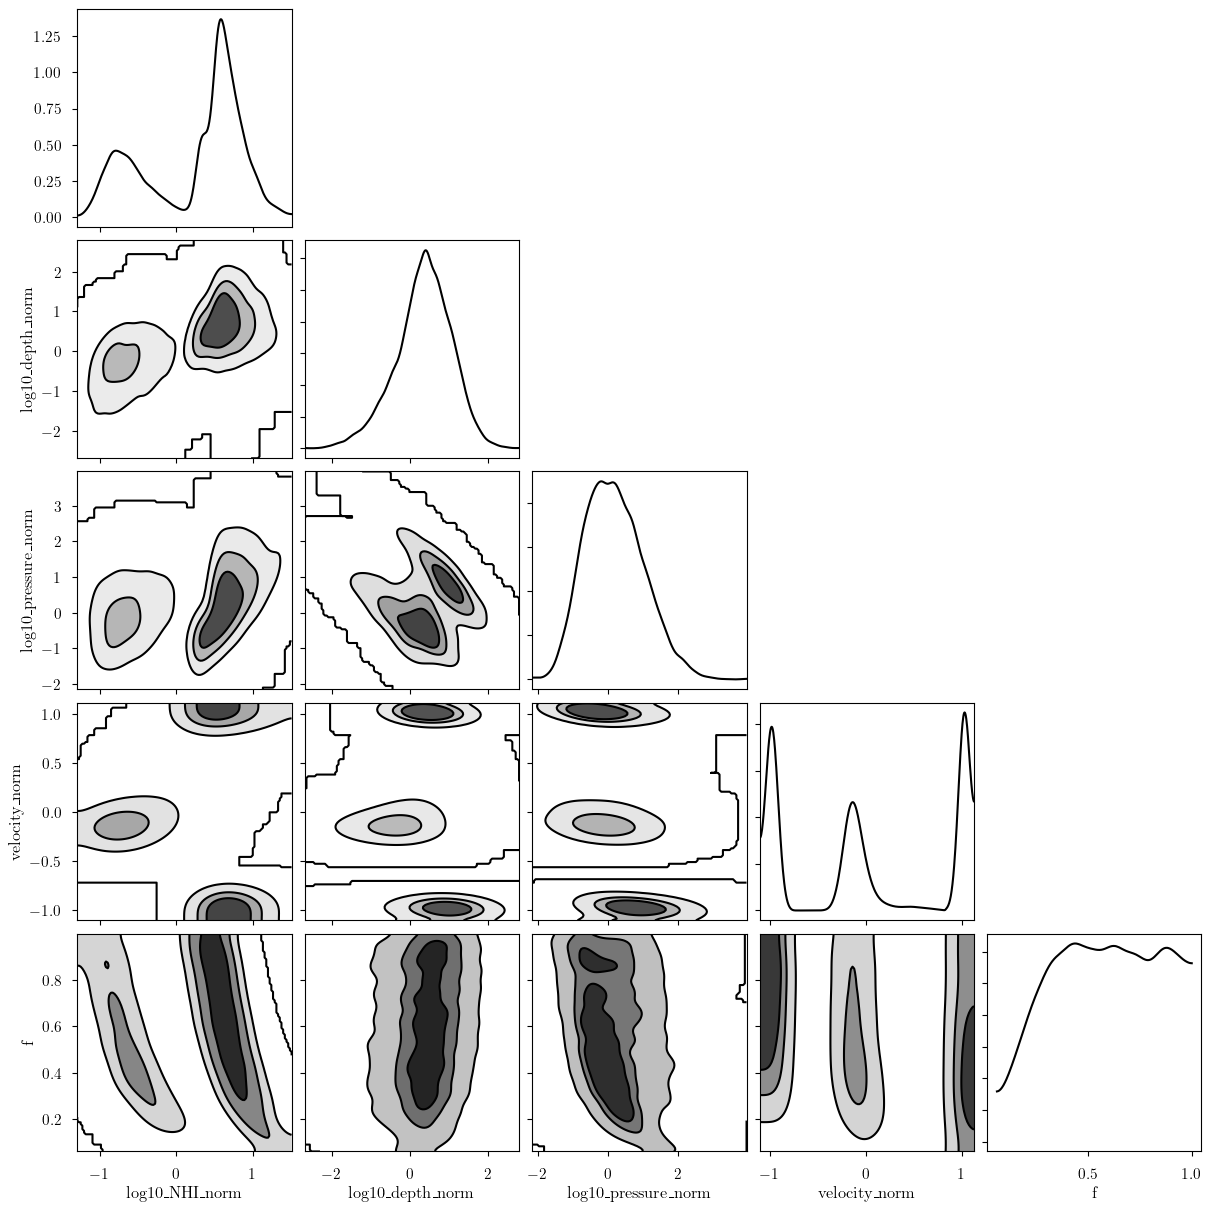

In [20]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    model.trace.solution_0,  # samples
    model.cloud_freeRVs,  # var_names to plot
    labeller=model.labeller,  # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. Also notice the tight correlation between column density and excitation temperature: optical depth spectra alone struggle to break this degeneracy!

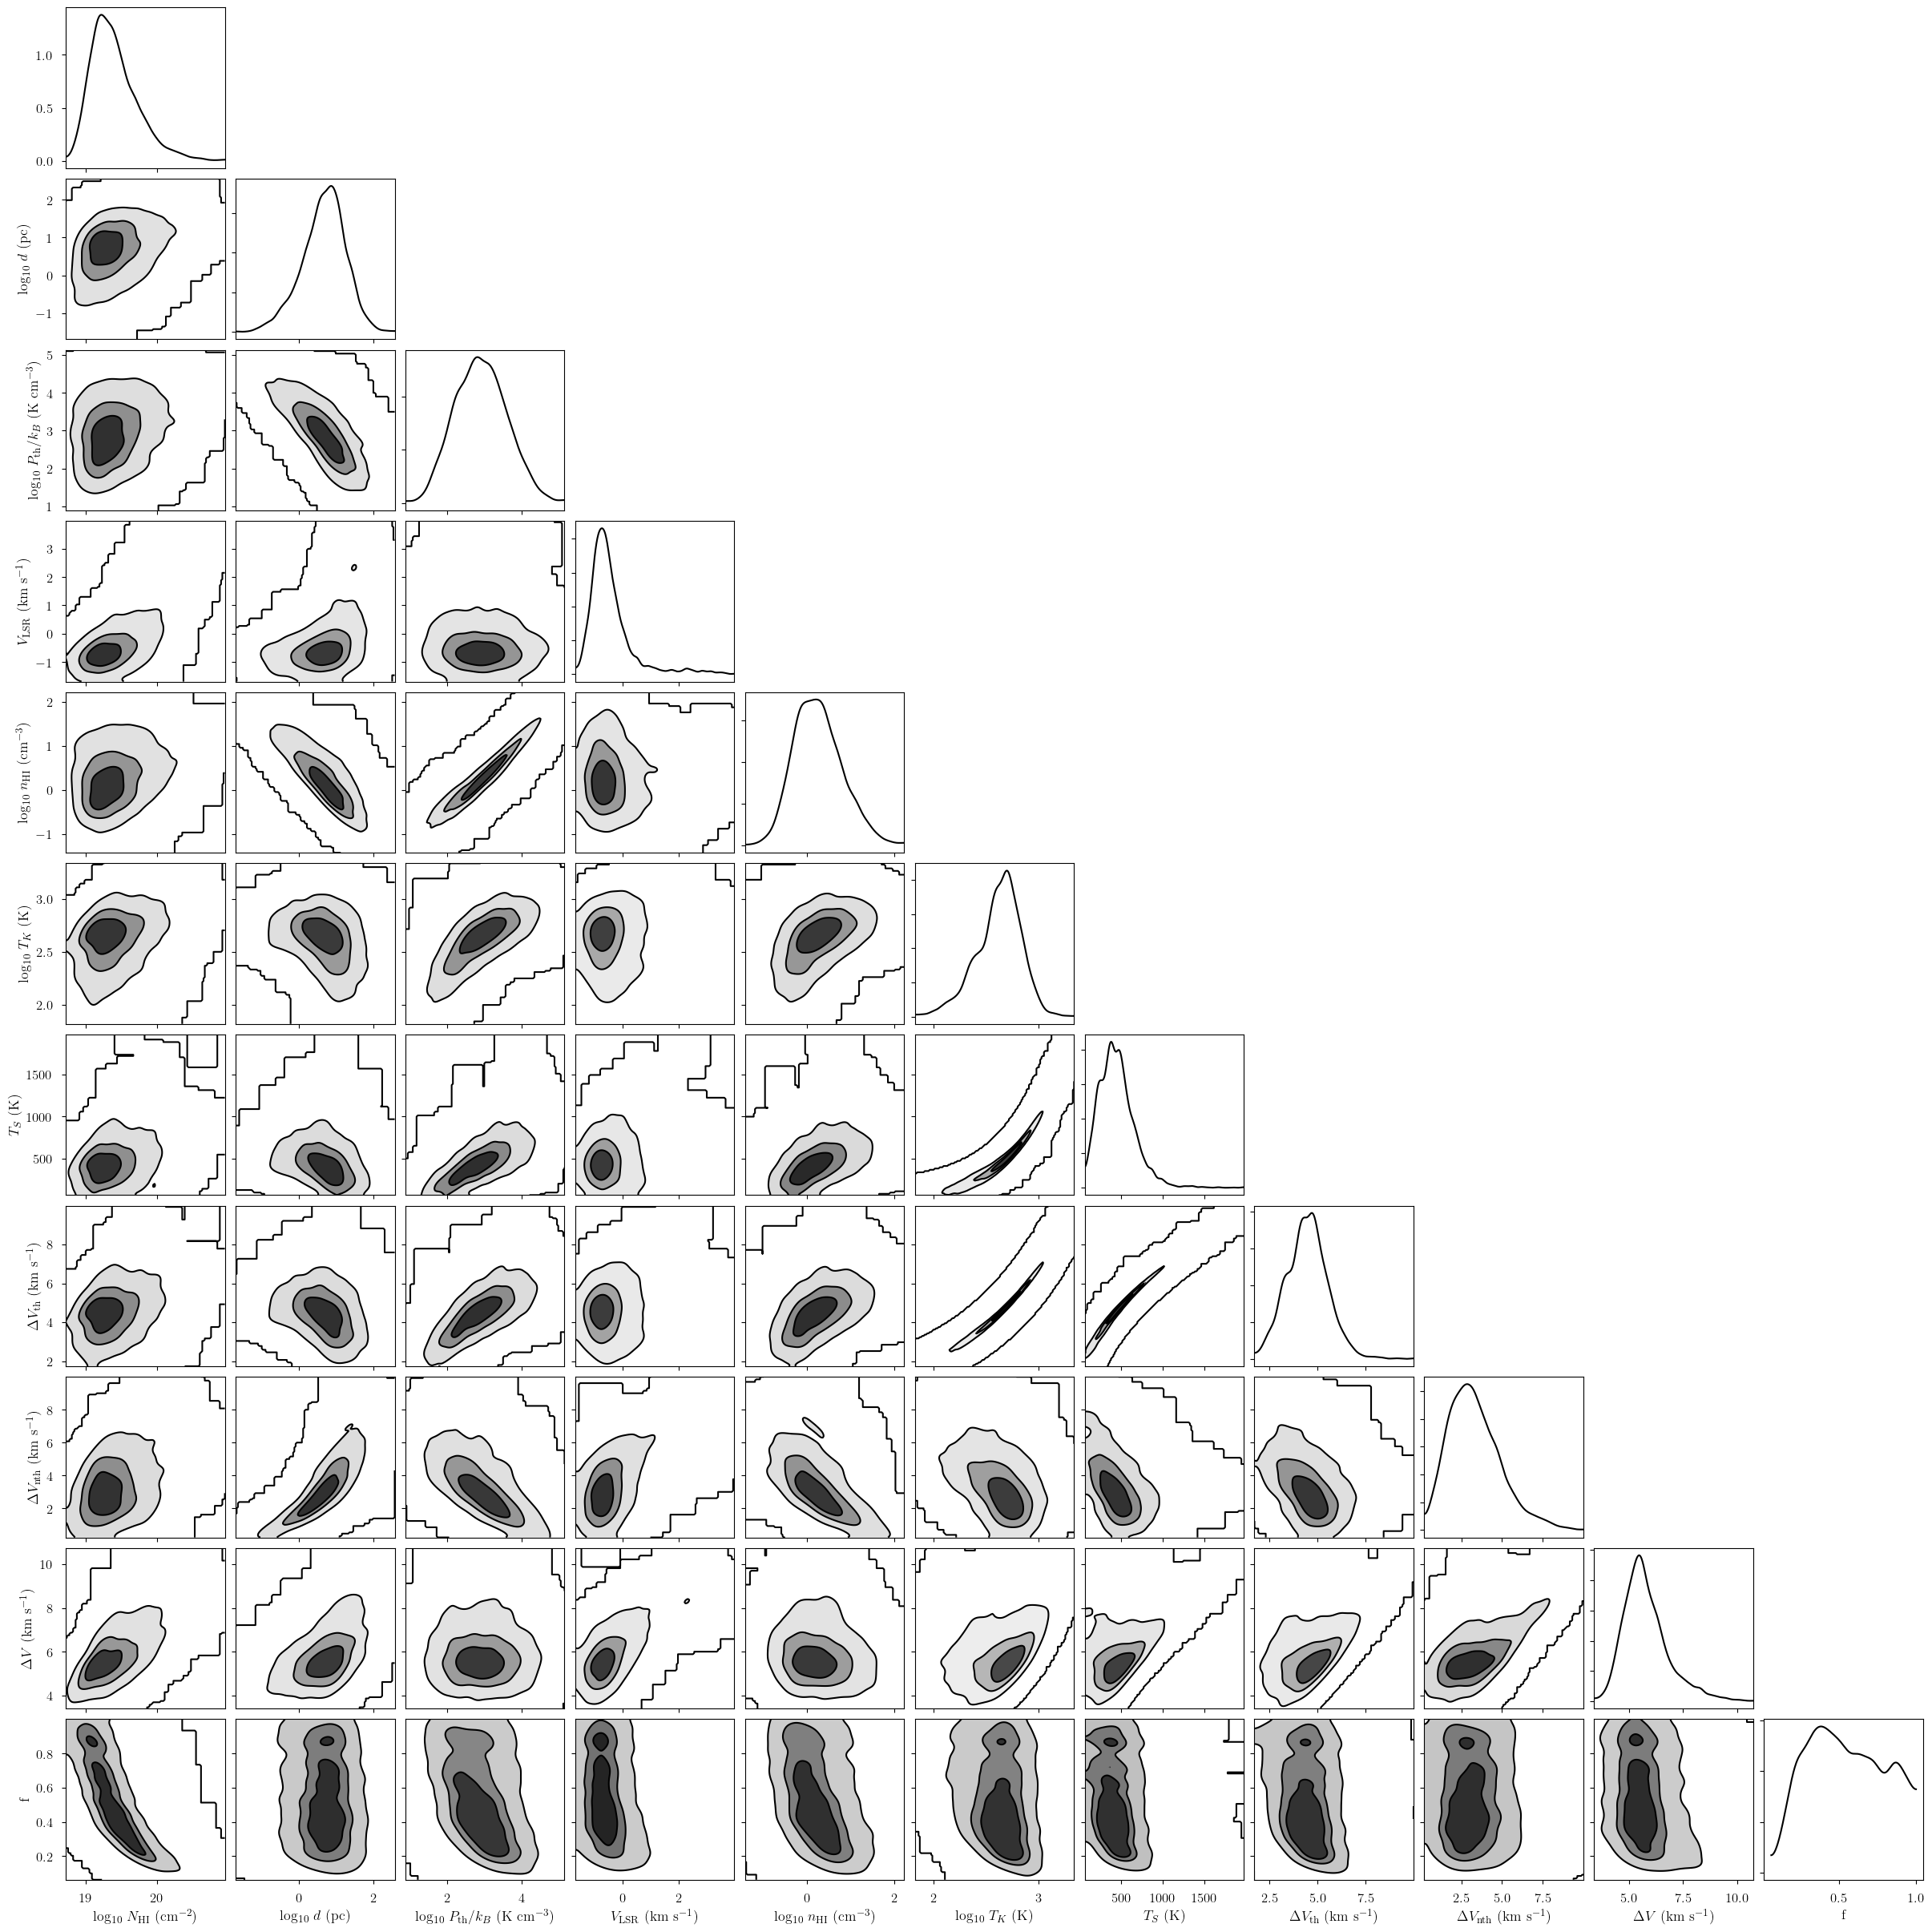

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0),  # samples
    model.cloud_deterministics + ["filling_factor"],  # var_names to plot
    labeller=model.labeller,  # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [22]:
point_stats = az.summary(model.trace.solution_0, kind="stats", hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -862.9033335312719


mean        sd   hdi_16%   hdi_84%
baseline_absorption_norm[0]    -0.472     0.022    -0.494    -0.452
baseline_emission_norm[0]      -0.522     0.002    -0.523    -0.520
filling_factor[0]               0.549     0.238     0.211     0.744
filling_factor[1]               0.665     0.209     0.547     0.991
filling_factor[2]               0.519     0.262     0.136     0.726
fwhm[0]                         5.801     1.052     4.625     6.386
fwhm[1]                        16.472     0.166    16.304    16.630
fwhm[2]                         6.535     0.097     6.473     6.640
fwhm_nonthermal[0]              3.333     1.584     1.399     4.356
fwhm_nonthermal[1]              9.739     3.455     7.490    14.592
fwhm_nonthermal[2]              5.957     0.573     5.925     6.413
fwhm_thermal[0]                 4.474     1.062     3.349     5.440
fwhm_thermal[1]                12.553     2.647    10.963    16.213
fwhm_thermal[2]                 2.466     0.902     1.540     2.628
larson_power                    0.391     0.082     0.300     0.462
larson_power_norm              -0.086     0.822    -1.000     0.621
log10_NHI[0]                   19.399     0.331    18.989    19.569
log10_NHI[1]                   20.706     0.160    20.501    20.762
log10_NHI[2]                   20.624     0.277    20.277    20.745
log10_NHI_norm[0]              -0.601     0.331    -1.011    -0.431
log10_NHI_norm[1]               0.706     0.160     0.501     0.762
log10_NHI_norm[2]               0.624     0.277     0.277     0.745
log10_depth[0]                  0.657     0.578     0.127     1.221
log10_depth[1]                  1.914     0.523     1.500     2.461
log10_depth[2]                  1.461     0.347     1.099     1.754
log10_depth_norm[0]            -0.343     0.578    -0.873     0.221
log10_depth_norm[1]             0.914     0.523     0.500     1.461
log10_depth_norm[2]             0.461     0.347     0.099     0.754
log10_larson_linewidth          0.219     0.097     0.123     0.314
log10_larson_linewidth_norm     0.188     0.966    -0.771     1.141
log10_nHI[0]                    0.253     0.550    -0.341     0.722
log10_nHI[1]                    0.303     0.562    -0.219     0.829
log10_nHI[2]                    0.674     0.449     0.198     1.030
log10_n_alpha                  -6.009     0.989    -7.058    -5.125
log10_n_alpha_norm             -0.009     0.989    -1.058     0.875
log10_pressure[0]               2.909     0.686     2.134     3.521
log10_pressure[1]               3.859     0.691     3.154     4.500
log10_pressure[2]               2.792     0.660     2.094     3.283
log10_pressure_norm[0]         -0.091     0.686    -0.866     0.521
log10_pressure_norm[1]          0.859     0.691     0.154     1.500
log10_pressure_norm[2]         -0.208     0.660    -0.906     0.283
log10_tkin[0]                   2.615     0.216     2.453     2.856
log10_tkin[1]                   3.515     0.200     3.428     3.766
log10_tkin[2]                   2.076     0.276     1.718     2.181
rms_absorption                  0.012     0.001     0.011     0.012
rms_absorption_norm             1.155     0.083     1.069     1.233
rms_emission                    0.094     0.005     0.089     0.098
rms_emission_norm               0.939     0.048     0.888     0.981
tspin[0]                      454.565   213.268   197.707   574.687
tspin[1]                     3257.942  1353.851  1259.296  4297.634
tspin[2]                      150.238   126.870    51.253   149.988
velocity[0]                    -0.428     0.813    -1.147    -0.183
velocity[1]                    -4.920     0.140    -5.033    -4.760
velocity[2]                     5.106     0.068     5.038     5.128
velocity_norm[0]               -0.086     0.163    -0.229    -0.037
velocity_norm[1]               -0.984     0.028    -1.007    -0.952
velocity_norm[2]                1.021     0.014     1.008     1.026